**@NuttidaLab: Tutorial on Bayesian Modeling**\
Date: 20th November 2024\
Author: Rudra

In [1]:
# # !conda create -n "tutorial" python=3.9 
# !conda activate tutorial 
# !pip install cmdstanpy
# !pip install pymc
# !pip install dynamax
# !pip install scipy==1.12
# !pip install ipywidgets
# !pip install seaborn
# !pip install numpyro
# !install_cmdstan

# # Optionally
# !conda update --all
# !conda install -c anaconda notebook 
# !conda install -c conda-forge jupyter_contrib_nbextensions 

In [2]:
# @utility
# Math imports
import math
from functools import partial
from itertools import count
import numpy as np
from scipy.stats import norm, poisson, expon, uniform, binom, beta, halfnorm
import jax.numpy as jnp
import jax.random as jr
# from jax import vmap

# Data imports
import tempfile
import pandas as pd

# Model imports
# import pymc as pm
from cmdstanpy import CmdStanModel
from dynamax.hidden_markov_model import GaussianHMM
from dynamax.hidden_markov_model import LinearRegressionHMM
from dynamax.utils.utils import find_permutation

# Plotting imports
from IPython.display import display
import ipywidgets as widgets
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import matplotlib.pyplot as plt
# import arviz as az
import seaborn as sns
#sns.set_theme(style="white") # options: darkgrid, whitegrid, dark, white, ticks
# az.style.use("arviz-white")
plt.rcParams['figure.dpi'] = 300

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


In [3]:
time_by_neur_by_region = {}

for region in ['ACC', 'amygdala', 'hippocampus', 'preSMA', 'vmPFC']:

    df_time_by_neur = pd.read_pickle(f'./data_files/time_by_neurs/{region}.pkl')
    time_by_neur_by_region[region] = df_time_by_neur.values.T
    print(f'{region}: {time_by_neur_by_region[region].shape}')


ACC: (170, 477)
amygdala: (328, 477)
hippocampus: (192, 477)
preSMA: (236, 477)
vmPFC: (116, 477)


In [4]:
region = 'amygdala'
tst = jnp.array(time_by_neur_by_region[region].reshape(328, 477, 1))
tst.shape

(328, 477, 1)

In [5]:
# Initialize the parameters using K-Means on the full training set
key = jr.PRNGKey(0)
t_hmm = GaussianHMM(num_states=15, emission_dim=1, transition_matrix_stickiness=10.)
params, props = t_hmm.initialize(key=key, method="kmeans", emissions=tst)
params, lps = t_hmm.fit_em(params, props, tst, num_iters=100)

<Axes: >

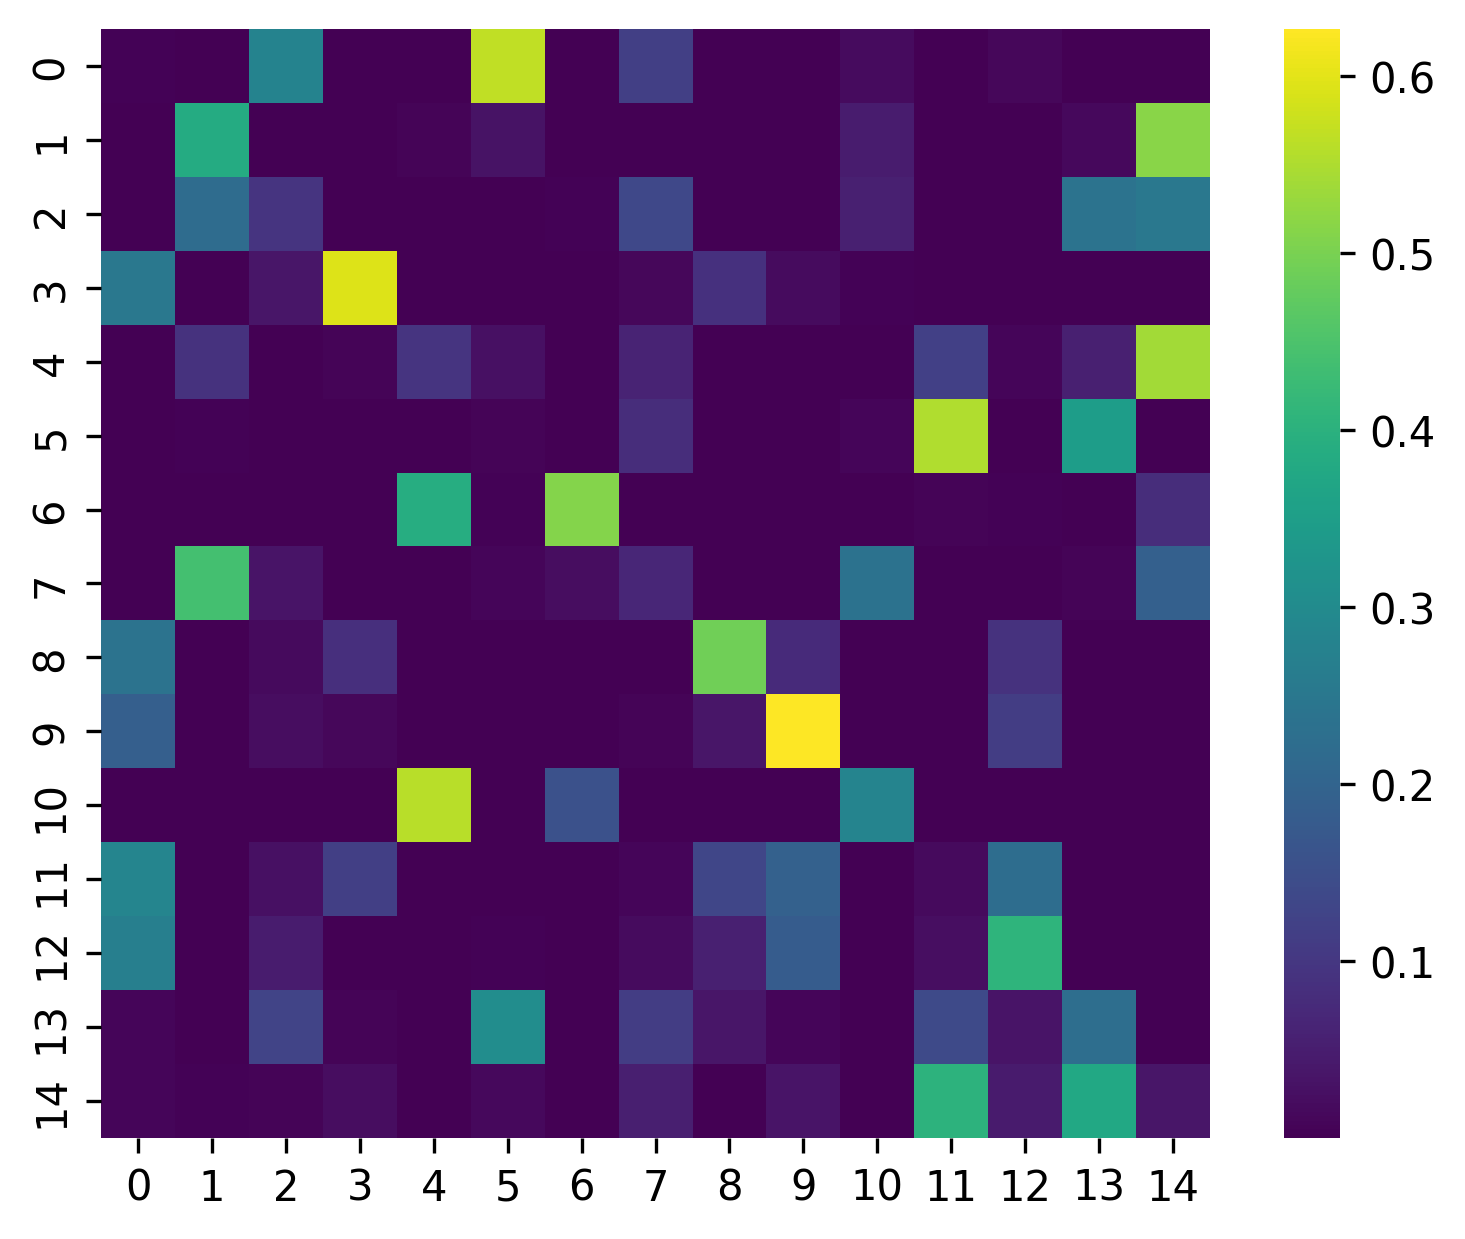

In [6]:
# plt.figure(figsize=(5, 5))
sns.heatmap(params.transitions.transition_matrix, cmap="viridis", square=True, cbar=True)

In [7]:
def plot_states(true_states, most_likely_states, emissions, title="Did the HMM get it right?"):
    # Plot the true and inferred states
    fig, axs = plt.subplots(2, 1, sharex=True, gridspec_kw={"height_ratios": [2, 2]}, figsize=(12, 6))

    for i, states in enumerate([true_states, most_likely_states]):
        offsets = 3 * jnp.arange(emission_dim)
        axs[i].imshow(states[None, :],
                    extent=(0, num_timesteps, em_min, em_max),
                    aspect="auto",
                    cmap="binary",
                    alpha=0.5)
        axs[i].plot(emissions + offsets, 'k-', marker='.')
        axs[i].scatter(jnp.arange(num_timesteps), emissions, c=emissions, cmap=col_line, marker='o', s=100)
        axs[i].set_xlim(0, num_timesteps)
        axs[i].set_ylim(em_min, em_max)
        axs[i].set_ylabel("emissions")
        axs[i].set_xlabel("time")

    axs[0].set_title("true states")
    axs[1].set_title("inferred states")
    plt.suptitle(title)

In [9]:
# Compute the most likely states
most_likely_states = t_hmm.most_likely_states(params, tst[0])
# plot_states(most_likely_states, most_likely_states, tst[0])

In [10]:
most_likely_states

Array([ 9,  0,  5,  7,  1,  1,  1,  1,  1,  1, 14,  9, 12, 12, 12,  9,  0,
        5, 13,  5, 11,  0,  5, 11, 12,  0,  7, 14, 11,  0,  5, 13, 11,  0,
        5, 11,  8,  8,  8,  8,  9,  2,  1, 14, 11,  0,  5, 11, 12,  9,  9,
        9,  9,  8,  8,  8,  8,  8,  8,  9,  9,  9,  9,  9, 12, 12, 12,  9,
       12, 12, 12,  9,  0,  2, 14, 11, 12,  9,  9,  0,  2, 13,  5, 11, 12,
       12,  9,  0,  5, 11,  8,  8,  8,  9,  0,  5, 11, 12,  0,  5, 11,  9,
        0,  2,  1, 14, 11, 12,  9,  9,  0,  5, 11, 12, 12,  9,  9,  0,  5,
       13,  5, 13,  8,  8,  8,  8,  8,  0,  5, 13,  2,  1,  1, 10, 10, 10,
       10,  4, 14, 11, 12,  0,  5, 13,  8,  8,  0,  2, 14, 11, 12,  0,  2,
        1, 14, 11,  9,  9,  0,  5,  7,  1,  1, 14, 11,  0,  2,  1, 14, 11,
        0,  7,  1,  1, 10,  6,  6,  4,  7, 10, 10,  4, 11,  9,  9,  9,  0,
        5, 11, 12, 12,  9,  9,  9,  9, 10, 10,  4, 11,  0,  7, 14,  7,  6,
        6,  6, 14, 13,  5, 11, 12,  0,  5, 13,  5, 11,  0,  2, 14, 11, 12,
        0,  5, 13,  5, 13

# 0.0 Refresher

### 1.1 Probability and Quantifying Variability

Probability is defined as a number between 0 and 1, which describes the likelihood of the occurrence of some particular event in some range of events. 0 means an infinitely unlikely event, and 1 means the certain event. The term ‘event’ is very general, but for us can usually be thought of as one sample data point in an experiment, and the ‘range of events’ would be all the data we would get if we sampled virtually an infinite dataset on the experiment. For now, We are only interested in quantifying the sample variability. [ref](https://geofaculty.uwyo.edu/neil/teaching/Numerical_web/Yaxis_values.pdf)

Imagine a bag with red and blue balls as such:

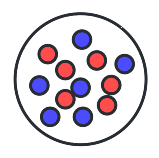

6 red balls and 6 blue balls.


If you randomly "sample" one ball (a.k.a. event), the probability of getting a red ball is the fraction of red balls to the total.

$$
P(Red)= \frac {\text{Number of Red Balls}​} {\text{Total Number of Balls}}\\
$$

Similarly, the probability of getting a blue ball is the fraction of blue balls to the total.
$$
P(Blue)= \frac {\text{Number of Blue Balls}​} {\text{Total Number of Balls}}\\
$$

And the sum of the probabilities of all possible outcomes would be 1.
$$
P(Red) + P(Blue) = 1
$$

If you sampled a ball and put it back in the bag, the probability of getting a red ball would be the same on the next draw.\
However, if you sampled a ball and didn't put it back in the bag, the probability of getting a red ball would change for the next draw. (It would be less than previous event)\
This is because the sample space has changed (we wont go too much into this for now).

**For the rest of this tutorial, we will assume that the generative process that makes these balls can infinitly keep making balls and we can draw as much as we want to discover the true distribution.**\
If you sampled a ball and put it back in the bag, that is your generative process.\
In this manner, if you repeatedly sample from the bag, there is no limit to the number balls you could draw.\
With sufficient draws you can be more and more confident about the vraiability in the probability and the true distribution in the generative process.\
With a large dataset, the sample probability will converge to the true probability which sould be .5/.5 in this case.

***Run the code cell below multiple times and see which graph changes most dramatically between runs***

In [ ]:
# @utility
# show the probabiltity converging to .5 .5 with increasing number of samples from a np.random.choice(["red", "blue"])
n_draws = [5, 10, 100, 1000, 10000]
color=["#ff4c4c", "#4c4cff"]

# bar graphs for each n_draws with the variance of the probability (error bars)
fig, ax = plt.subplots(1, 5, figsize=(20, 3))
for i, n in enumerate(n_draws):
    data = np.random.choice(["red", "blue"], n)
    p = np.mean(data == "red")
    var = p * (1 - p) / n
    ax[i].bar(["red", "blue"], [p, 1 - p], color=color)
    ax[i].errorbar(["red", "blue"], [p, 1 - p], yerr=var, fmt="none", ecolor="black", capsize=5)
    ax[i].set_title(f"n = {n}")
    ax[i].set_ylim(0, 1)

### 1.2 Updating beliefs with new data

As you intuitively understood from above experiment, as you draw more and more samples, you can be more and more confident about the true distribution of the balls in the bag.\
This is the **basis of Bayesian statistics**.

We can formalize this process with Bayes' theorem:

$$
P(\text{Red | Data}) = \frac{P(\text{Data | Red}) P(\text{Red})}{P(\text{Data})}
$$
Where:
- $ P(\text{Red}) $: Prior belief about the proportion of red balls.
- $ P(\text{Data | Red}) $: Likelihood of observing the data given the proportion of red balls.
- $ P(\text{Data}) $: Total probability of observing the data.

So, basically, as you you aquired more data, you updated your belief about the proportion of red balls in the bag. (which in this case is the same as the probability)

### 1.3 Discrete to Continuous space

**Notice** how you could either get a red ball or either a blue ball. This means your **choices are discrete.**

Sometimes, it is possible that the generative process is **continuous**.\
Such as, what if the bag had balls in a **spectrum of colors** between red and blue and till now you were only sampling from a specific subset of the dataset. And now for some unknown reason, the generative process has changed and you are now sampling from the whole dataset.\
As such:

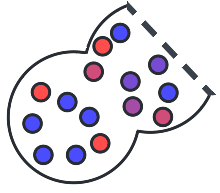


To discover this new true distribution of the generative process, we make histograms of the samples we draw.\
By making the buckets in the histograms thinner and thinner (to infinity), we can get a better idea of the ***true continuous distribution***.

In [ ]:
# @Utility

# Define colors for red and blue gradient
def get_color_gradient(n, color1="red", color2="blue"):
    cmap = mcolors.LinearSegmentedColormap.from_list("gradient", [color1, color2])
    return [cmap(i / (n - 1)) for i in range(n)]

# Normal distribution parameters
mu, sigma = 0, 1
# Prepare the plot
num_bins_list = [2, 5, 10, 26]  # Number of discrete approximations

# Function to create PMF approximation
def create_pmf(num_bins, mu, sigma):
    bins = np.linspace(-3, 3, num_bins + 1)
    bin_centers = (bins[:-1] + bins[1:]) / 2
    pmf_values = norm.pdf(bin_centers, mu, sigma)
    return bins, bin_centers, pmf_values

def plot_approximation(num_bins_list, mu, sigma):
    fig, axes = plt.subplots(1, len(num_bins_list), figsize=(20, 3), sharex=False)
    for ax, num_bins in zip(axes, num_bins_list):
        bins, bin_centers, pmf_values = create_pmf(num_bins, mu, sigma)
        gradient_colors = get_color_gradient(num_bins, color1="red", color2="blue")

        # Plot bars and assign colors
        ax.bar(bin_centers, pmf_values, width=(bins[1] - bins[0]), color=gradient_colors, edgecolor='black', alpha=0.7)

        # Plot balls as dots above the bars
        for center, value, color in zip(bin_centers, pmf_values, gradient_colors):
            ax.plot(center, value + 0.05, 'o', color=color, markersize=8)

        # Label and title
        ax.set_title(f"PMF Approximation with {num_bins} Balls")
        ax.set_ylabel("Probability (Mass Density)")
        ax.set_xticks(bin_centers)
        ax.set_xticklabels([f"{chr(97 + i)}" for i in range(num_bins)])
        ax.set_xlabel("Smaller bin sizes for better Approximations")

    plt.show()

plot_approximation(num_bins_list, mu, sigma)

Transitioning from a discrete probability to a continuous probability involves shifting from assigning probabilities to distinct, separate outcomes to describing probabilities across a continuum of possibilities.\
Additionally, what if the underlying generative process has **changed the odds** of getting different colors of balls?\
for example:

In [ ]:
# Normal distribution parameters
mu, sigma = 1, 1
num_bins_list = [2, 5, 10, 26]  # Number of discrete approximations
plot_approximation(num_bins_list, mu, sigma)

**We need a way to model this continuous distribution!**\
To do this, we assume that the histogram is an approximation of a continuous function which describes a probability distribution.\
And we map our histogram to the "best suited" continuous function hoping that this is the true distribution of the generative process.

Below are some examples of different continuous functions that can be used to approximate the histogram:

In [ ]:
# @Utility

x_values = {
    "Normal": np.linspace(-4, 4, 1000),
    "Poisson": np.arange(0, 10, 0.1),  # Approximation for visualization
    "Exponential": np.linspace(0, 8, 1000),
    "Uniform": np.linspace(-0.5, 1.5, 1000),  # Extending slightly beyond range for visualization
    "Half-Normal": np.linspace(0, 4, 1000),
    "Beta": np.linspace(0, 1, 1000),
}

# Corresponding probability density/mass functions
pdfs = {
    "Normal": norm.pdf(x_values["Normal"], loc=0, scale=1),
    "Poisson": poisson.pmf(x_values["Poisson"].astype(int), mu=3),
    "Exponential": expon.pdf(x_values["Exponential"], scale=1),
    "Uniform": uniform.pdf(x_values["Uniform"], loc=0, scale=1),
    "Half-Normal": halfnorm.pdf(x_values["Half-Normal"]),
    "Beta": beta.pdf(x_values["Beta"], a=.5, b=.5),
}

# Plotting continuous lines
plt.figure(figsize=(10, 5))
colors = get_color_gradient(len(pdfs))

for i, (dist_name, x_vals) in enumerate(x_values.items()):
    plt.subplot(2, 3, i + 1)
    plt.plot(x_vals, pdfs[dist_name], color=colors[i], label=f"{dist_name} PDF/PMF")
    plt.title(f"{dist_name} Distribution")
    plt.xlabel("Value")
    plt.ylabel("Density / Probability")

# plt.tight_layout()
plt.show()


***So which function should we choose?***

# Outline

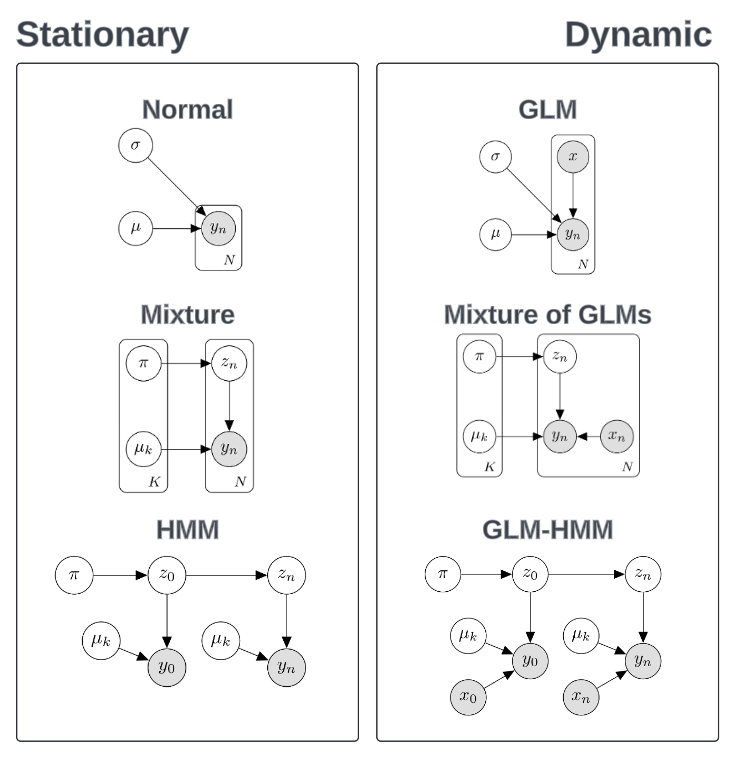

# 1.0 Stationary

## Bayesian Thinking

### Probality Interpretation

Choosing the right distribution is a question of what fits the data best.\
And **when we are aproximating the data, we are fitting a model!**

There are 2 schools of thought on this:  
1. **Frequentist**: They consider the data as fixed (given the experiment) and view the model parameters as unknown but fixed quantities. They use methods like Maximum Likelihood Estimation (MLE) to estimate the parameters that maximize the likelihood of observing the data.

2. **Bayesian**: They consider the data as observed, and the **model parameters as random variables with prior beliefs**. They use **Bayes' theorem to update their prior beliefs** about the parameters into posterior distributions based on the observed data.

**For the purpose of this tutorial, we will focus specifically on the Bayesian approach.**

### Bayesian Model Specification

**Bayesian model specification involves 3 components:**

1. **Prior**: The prior distribution describes the beliefs about the model parameters before observing the data. It is often assumed to be a normal distribution.
2. **Likelihood**: The likelihood function describes the probability of observing the data given the model parameters. It is the foundation of the model.
3. **Posterior**: The posterior distribution describes the updated beliefs about the model parameters after observing the data. It is calculated using Bayes' theorem.

We can update our beliefs about the generative process by using the posterior distribution:
$$Posterior = \frac{Likelihood \times Prior}{Evidence}$$


**For our example of the balls in the bag, we can specify the model as follows:**

**Prior**:
 
$$\mu \sim \mathcal{N}(0, 1)$$ 
$$\sigma \sim |\mathcal{N}(0, 1)|$$

**Likelihood**:
$$y \sim \mathcal{N}( \mu, \sigma^2)$$


**Posterior**:
$$P(\mu, \sigma | y) = \frac{P(y | \mu, \sigma) P(\mu) P(\sigma)}{P(y)}$$

**Where**:
- $y$ is the data (balls drawn from the bag).
- $\mu$ is the mean of the distribution.
- $\sigma$ is the standard deviation of the distribution.
- $\mathcal{N}$ is the normal distribution.


A nice way to visualize this is through a simple graphical model:

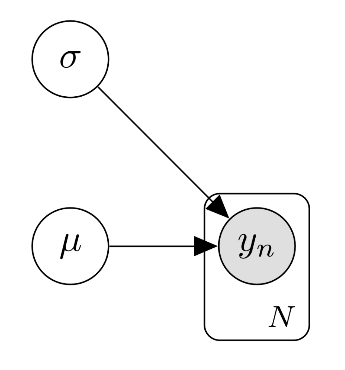

Indicates that there are $ N $ independent and identically distributed (i.i.d.) observations $ y_1, y_2, \dots, y_N $.

### Inference

Yayy, now that we have everything, *LETS GO AND SOLVE IT!!!!*\
But wait, how do we solve it?

Solving means calculating the posterior distribution $P(\mu, \sigma | y)$.

- **Analytically**:\
We can solve the posterior distribution analytically for simple models such as this.
- **Numerically**:\
For complex models, it is often **intractable to solve** the posterior distribution analytically. In such cases, we can use numerical methods like **Markov Chain Monte Carlo (MCMC)** or **Variational Inference (VI)** to approximate the posterior distribution.

**For the purpose of this tutorial, we will use MCMC to approximate the posterior distribution. As much as possible**

In [ ]:
#@utility
# Define the Stan model
model_specification = """
data {
    int<lower=0> N; // Number of data points
    array[N] real y; // Data
}
parameters {
    real mu; // Mean
    real<lower=0> sigma; // Standard deviation
}
model {
    // Priors
    mu ~ normal(0, 1);
    sigma ~ normal(0, 1);

    // Likelihood
    y ~ normal(mu, sigma);
}
"""

# Write the model string to a temporary file
with tempfile.NamedTemporaryFile(suffix=".stan", mode="w", delete=False) as tmp_file:
    tmp_file.write(model_specification)
    tmp_stan_path = tmp_file.name

# Prepare the unknown generator data
data = {
    "N": 1000,
    "y": np.random.normal(loc=1, scale=1, size=1000),
}

# Compile and fit the model
model = CmdStanModel(stan_file=tmp_stan_path)
fit = model.sample(data=data, iter_sampling=1000, step_size=0.1)

Now that we have approximated the posterior distribution and updated the prior beliefs.\
We can take a look at them. do they look like the true distribution of the generative process?

In [ ]:
#@utility
idata = az.from_cmdstanpy(fit)

# Plot the posterior distribution
ax = az.plot_posterior(idata, round_to=2, figsize=(8, 2), textsize=10)
plt.suptitle("Posterior Distribution of Parameters")
for a in ax: 
    a.set_ylabel("Density")
# plt.tight_layout()
plt.show()

**Notes**:
- It seems like the model has updated its prior beliefs and landed on ~1.1 for $\mu$ and ~0.9 for $\sigma$ which is very close to the true distribution of the generative process (1 $\mu$ and 1 $\sigma$).
- The model is uncertain about it's estimation only to a very small degree. The range for $\mu$ is 1 to 1.1 and for $\sigma$ is 0.95 to 1. It is essentially pretty certain about these parameters.

**Let's now visualize the fit of the model to the data.**

In [ ]:
#@utility
num_bins = 26

all_mu = idata.posterior.mu.values.flatten()
all_sigma = idata.posterior.sigma.values.flatten()

# make linespace and make the pdf
x = np.linspace(-5, 5, 1000)

# Plot the histogram and the posterior predictive distribution
plt.figure(figsize=(6, 3))

# Plot the data used to fit the model
_, _, patches = plt.hist(data["y"], bins=num_bins, density=True, edgecolor='black', color="skyblue", alpha=0.7, label="Data")
for i in range(len(patches)): patches[i].set_facecolor(get_color_gradient(num_bins)[i])

# Plot the uncertainty in the model
for i in range(len(all_mu)):
    pdf = norm.pdf(x, loc=all_mu[i], scale=all_sigma[i])
    plt.plot(x, pdf, color="orange", alpha=0.003)

# Plot the mean of the posterior predictive distribution
mean_pdf = norm.pdf(x, loc=all_mu.mean(), scale=all_sigma.mean())
abc = plt.plot(x, mean_pdf, "k--", label="Mean Post. Predictive")

plt.legend(loc='upper left')

plt.title("Posterior Predictive Distribution and Uncertainty")
plt.ylabel("Density")
plt.xlabel("y")
plt.xlim(-4, 4)
plt.show()

## Mixtures

Now, suppose our generative process has changed. Previously, we assumed it generated data from a single continuous distribution. However, now the data appears to come from multiple **subpopulations** or **components**, and our goal is to model this situation. This scenario is best described by **Mixture Models**. 

You can think of it as a bag with multiple bags inside it, each containing different preference for balls of different colors.

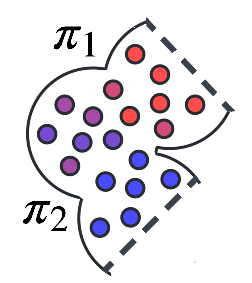

### What is a Mixture Model?

A mixture model is a probabilistic model that assumes:
1. The observed data is drawn from a combination of **multiple distributions**, each representing a distinct **component** in the data.
2. Each data point is generated by:
   - First selecting a **component** (randomly, based on a probability distribution over the components),
   - Then drawing a sample from the distribution corresponding to the chosen component.

### Components of a Mixture Model

#### **Latent Variable (Component Selection)**
- Let $ z_n $ represent the **latent variable** (hidden category) for the $ n $-th observation, indicating which component the observation belongs to.
- $ z_n \in \{1, 2, \dots, K\} $, where $ K $ is the number of components.

#### **Mixing Weights (Component Probabilities)**
- Each component $ k $ is associated with a probability $ \pi_k $, called the **mixing weight**, representing how likely a sample belongs to this component.
- Mixing weights satisfy:
  $$
  \sum_{k=1}^K \pi_k = 1 \quad \text{and} \quad \pi_k > 0 \, \forall k.
  $$
**note**: $\forall$ means "for all" :)

#### **Component Distributions**
- Each component $ k $ has a distribution (e.g., Gaussian, Poisson, etc.) with its own parameters $ \theta_k $. For instance, in the case of a Gaussian Mixture Model (GMM), $ \theta_k = (\mu_k, \sigma_k) $.


### The Probabilistic Structure

The generative process for each data point $ y_n $ is as follows:
1. Draw a component $ z_n $ from the categorical distribution:
   $$
   z_n \sim \text{Categorical}(\pi_1, \pi_2, \dots, \pi_K)
   $$
2. Given $ z_n = k $, draw the observation $ y_n $ from the corresponding component distribution:
   $$
   y_n \sim f(y | \theta_k)
   $$

### Joint and Marginal Distributions

1. **Joint Probability of Observing $ (z_n, y_n) $:**
   $$
   P(z_n, y_n) = P(z_n) P(y_n | z_n)
   $$

2. **Marginal Probability of $ y_n $:**
   - By marginalizing over the latent variable $ z_n $:
   $$
   P(y_n) = \sum_{k=1}^K P(z_n = k) P(y_n | z_n = k)
   $$
   - Substituting $ P(z_n = k) = \pi_k $:
   $$
   P(y_n) = \sum_{k=1}^K \pi_k f(y_n | \theta_k)
   $$
   - **This is the most common representation of mixture models!**

Intuitively, we can visualize the mixture model as follows:

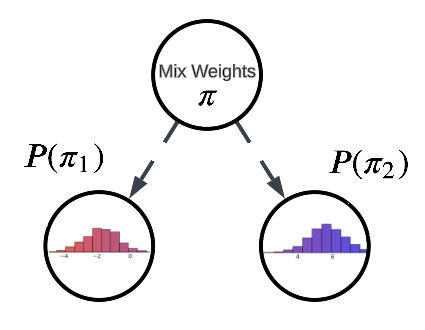

### Probabilistic Graphical Model

Below is the corresponding **probabilistic graphical model (PGM)** that illustrates the dependencies in a mixture model. The **plate notation** indicates repeated variables for $ n = 1, \dots, N $ observations and $ k = 1, \dots, K $ components.

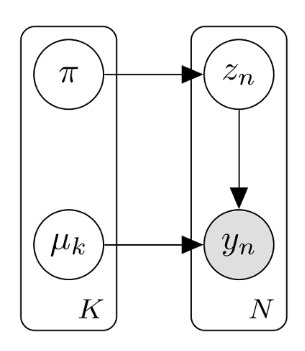


- $ \pi $: Mixing weights (shared across all data points).
- $ z_n $: Latent variable (which component generated the $ n $-th observation).
- $ \mu_k $: Parameters of the $ k $-th component (e.g., mean in a GMM).
- $ y_n $: Observed data.



This framework captures the **hierarchical structure**:
- $ z_n $ determines which component $ y_n $ is drawn from.
- $ \pi $ controls the probabilities of the components.
- $ \mu_k $ determines the shape of each component.

### Bayesian Specification

In the Bayesian framework, we consider the following components:
1. **Priors**:
   - $ \pi \sim \text{Dirichlet}(\alpha_1, \dots, \alpha_K) $ (mixing weights),
   - $ \theta_k \sim \text{Prior for component parameters (e.g., Gaussian)} $.

2. **Likelihood**:
   - The likelihood of observing $ y_n $, given the parameters $ \pi $ and $ \theta $, is:
   $$
   P(y_n | \pi, \theta) = \sum_{k=1}^K \pi_k f(y_n | \theta_k)
   $$

3. **Posterior**:
   - Using Bayes’ theorem, the posterior distribution updates our beliefs about the parameters based on the observed data:
   $$
   P(\pi, \theta | y) \propto P(y | \pi, \theta) P(\pi) P(\theta)
   $$

### Inference in Mixture Models (Example with PyMC)

Now lets simulate a mixture model and infer the parameters using MCMC.
Use the sliders below to generate any dataset you want! 😃

In [ ]:
def plot_mixture(y, imeans = None, iweights = None, show_comps=False, ax = None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(8, 3))

    # Plot the mixture
    _,_,patches = ax.hist(y, bins=26, density=True, edgecolor='black', color="skyblue", alpha=0.7, label="Data")
    for i, patch in enumerate(patches):
        patch.set_facecolor(get_color_gradient(26)[i])

    if imeans is not None and iweights is not None:
        # Create a range of x values
        x = np.linspace(-5, 8, 1000)

        # Plot the mixture uncertainty
        for i in range(len(iweights)):
            pdf = iweights[i,0] * norm.pdf(x, loc=imeans[i,0], scale=1) + iweights[i, 1] * norm.pdf(x, loc=imeans[i, 1], scale=1)
            ax.plot(x, pdf, color="orange", alpha=0.003)

        # Plot the mixture mean
        mixture_density = iweights.mean(axis=0)[0] * norm.pdf(x, imeans.mean(axis=0)[0], 1)\
            + iweights.mean(axis=0)[1] * norm.pdf(x, imeans.mean(axis=0)[1], 1)
        ax.plot(x, mixture_density, "k--", label="Mixture Mean")

    # Plot the components
    if show_comps:
        for weight, mean in zip(iweights.mean(0), imeans.mean(0)):
            component_density = weight * norm.pdf(x, mean, 1)
            ax.plot(x, component_density, linestyle = "--", alpha=0.9, label=f"Component: μ={mean:.2f}")
    
    ax.set_title("Mixture of Gaussians")
    ax.set_xlabel("y")
    ax.set_ylabel("Density")
    ax.set_xlim(-5, 8)
    ax.set_ylim(0, 0.5)
    ax.legend()
    # ax.grid()
    # ax.show()

In [ ]:
a = widgets.FloatSlider(value=0.7, min=0, max=1)
mean_a = widgets.FloatSlider(value=0, min=-5, max=8)
mean_b = widgets.FloatSlider(value=4, min=-5, max=8)

# True Parameters for the mixture components
def update_plot(weight, mean_1, mean_2):
    # Generate synthetic data from the inputs
    components = np.random.choice(2, size=2000, p=[weight, 1-weight])
    global y # Ewww but it's okay for now
    y = np.array([np.random.normal([mean_1, mean_2][k], 1) for k in components])
    plot_mixture(y=y)

w=widgets.interactive(update_plot,weight=a,mean_1=mean_a,mean_2=mean_b)
display(w)

In [ ]:
# Mixture of Normal Components
with pm.Model() as model:
    # Priors
    w = pm.Dirichlet("w", a=np.array([1, 1]))  # 2 mixture weights (SAME AS BETA)
    mu1 = pm.Normal("mu1", 0, 1)
    mu2 = pm.Normal("mu2", 0, 1)

    components = [
        pm.Normal.dist(mu=mu1, sigma=1),
        pm.Normal.dist(mu=mu2, sigma=1),
    ]

    like = pm.Mixture("like", w=w, comp_dists=components, observed=y)

    # Sample
    trace = pm.sample(1000, chains=1)

In [ ]:
# Taking the posteriors from only the first chain for simplicity
imeans = np.array([trace.posterior.mu1[0].values, trace.posterior.mu2[0].values]).T
iweights = trace.posterior.w[0].values
plot_mixture(y, imeans, iweights, show_comps=False)
ax = az.plot_posterior(trace, figsize=(20, 2), round_to=2)
for a in ax.flatten(): a.set_ylabel("Density")

**Notes:**

1. **Mixture Fit Results**:
   - The observed histogram shows two distinct peaks, which are well-captured by the **Mixture of Gaussians**.
   - The dashed black line represents the **mixture mean**, which combines the contributions of both components.

2. **Posterior Summaries**:
   - For $ \mu_1 $ (mean of the first component), the posterior mean is approximately **0.03**, indicating the first component centers near zero.
   - For $ \mu_2 $ (mean of the second component), the posterior mean is approximately **4.1**, reflecting the second component is centered around 4.
   - The weights $ w_0 $ and $ w_1 $ (mixing proportions) show posterior means of **0.7** and **0.3**, respectively, indicating the first component contributes 70% and the second contributes 30% to the mixture.

3. **Uncertainty in Estimation**:
   - The credible intervals (94% HDI) for all parameters are narrow, showing high confidence in the estimates for means ($ \mu_1, \mu_2 $) and weights ($ w_0, w_1 $).


Quiz: Mixture Peaks - From the plot, why does the first peak appear taller than the second? How do the weights influence this observation?

## A Markovian Situation

### Markov Process and Hidden Markov Models


Imagine our generative process has evolved again. Instead of sampling directly from a single bag or even from multiple nested bags (as in the mixture model), now we have a **sequence** of bags. The bag we sample from at any given step **depends on which bag we chose in the previous step**.

This situation introduces the concept of **dependencies in time or sequence**, where the current state depends on the previous one. Such a process can be described using **Markov Models**.

### What is a Markov Process?

A **Markov Process** models systems that evolve over time, where:
1. The system can be in one of several **states**.
2. The probability of transitioning to a new state depends only on the **current state** and not on the sequence of states before it. This is the **Markov Property**:
   $$
   P(z_n | z_{n-1}, z_{n-2}, \dots) = P(z_n | z_{n-1})
   $$

In our example, the system moves from one bag to another over time. The bag you pick your ball from at step $ n $ depends only on the bag you chose at step $ n-1 $.

### Introducing Hidden Markov Models (HMMs)

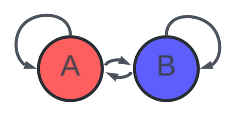

A **Hidden Markov Model (HMM)** extends a Markov Process by introducing **observations**. You no longer see the actual bag (state), but only the **ball** drawn from it (observation).


Key components of an HMM:
1. **Hidden States ($ z_n $)**:
   - Represent which "hidden bag" is active at each time step $ n $.
   - Transition between states is governed by the **transition probabilities**.

2. **Observations ($ y_n $)**:
   - Drawn from a Gaussian distribution parameterized by the **mean** ($ \mu_k $) and **variance** ($ \sigma_k^2 $) of the active state:
   $$
   y_n \sim \mathcal{N}(\mu_{z_n}, \sigma_{z_n}^2)
   $$

3. **Transition Probabilities ($ P(z_n | z_{n-1}) $)**:
   - Govern how likely it is to move from one state to another.
   - Captures the sequential dependencies in the generative process.

4. **Emission Probabilities ($ P(y_n | z_n) $)**:
   - Describe the distribution of balls in each bag.
   - E.g., a "red-dominant" bag emits more red balls, but it can still emit blue ones occasionally.




### Generative Process for an HMM

The generative process of an HMM can be described as follows:

1. **Transition**:
   - At time $ n $, transition to a new state $ z_n $ based on the current state $ z_{n-1} $:
   $$
   z_n \sim \text{Categorical}(\pi_{z_{n-1}})
   $$

2. **Emission**:
   - Once in state $ z_n $, generate an observation $ y_n $ from the Gaussian distribution of that state:
   $$
   y_n \sim \mathcal{N}(\mu_{z_n}, \sigma_{z_n}^2)
   $$


### Joint and Marginal Distributions

1. **Joint Probability of Observations and States**:
   $$
   P(y, z) = P(z_1) \prod_{n=2}^N P(z_n | z_{n-1}) P(y_n | z_n)
   $$

2. **Marginal Probability of Observations**:
   - By summing (marginalizing) over all possible hidden states:
   $$
   P(y) = \sum_{z_1, z_2, \dots, z_N} P(y, z)
   $$



You can also imagine this as a dynamic mixture model:

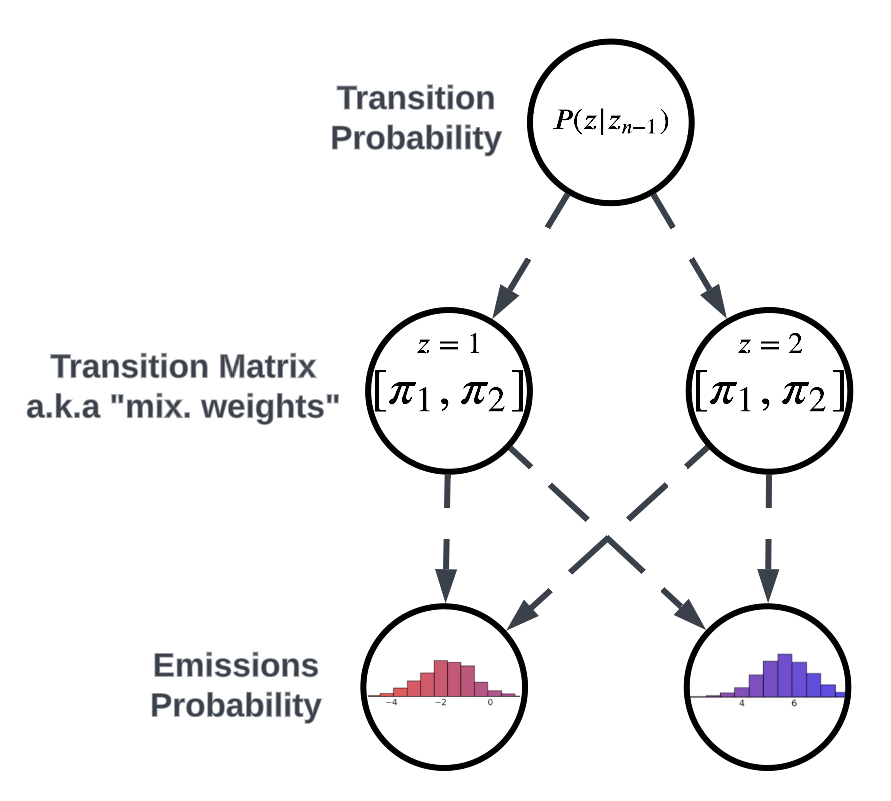


### Probabilistic Graphical Model

Below is the PGM illustrating the HMM. It shows the hierarchical dependencies:

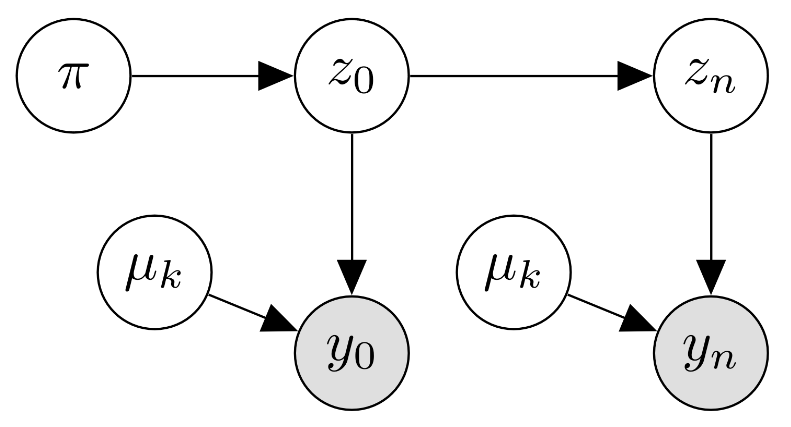

(removed sigma for simplicity)
- $ z_n $: Hidden state at time $ n $, governing the emission and the next state. (the bag)
- $ \mu_k$: Parameters of the Gaussian distribution for each hidden state.
- $ y_n $: Observed ball drawn at time $ n $.
- The arrows show how $ z_{n-1} $ influences $ z_n $, and $ z_n $ determines $ y_n $.

### Expectation-Maximization (Poor Man's Bayes)

The **Expectation-Maximization (EM)** algorithm is a (*almost) **frequentist approach** to solving Hidden Markov Models. Unlike full Bayesian inference, EM provides **point estimates** of the parameters (e.g., transition probabilities, means, variances) by maximizing the likelihood of the observed data. 

   - We wont have estimates for the **posterior distribution** of the parameters or uncertainty (credibility intervals).
   - EM gives a single "best guess" for the parameters (maximum likelihood estimates).
   - EM usually does not use priors on the parameters. (**But we can put them if we want!**). It solely relies on the data to optimize the likelihood.
   - EM is computationally faster and simpler since it avoids sampling (e.g., Markov Chain Monte Carlo).

### How to Solve a Hidden Markov Model?

Using **EM**, solving an HMM involves:
1. **E-Step**: Infer the hidden states based on the current parameter estimates.
2. **M-Step**: Update the parameters to maximize the likelihood given the inferred states.
3. **Repeat** until the parameters converge.

This approach works well for cases where we care about efficiency and are okay with point estimates, rather than capturing full uncertainty in the model parameters.

### Example: solving Gaussian HMM with EM

These are the true parameters of the generative process:

In [ ]:
num_train_batches = 3
num_test_batches = 1
num_timesteps = 200

# Make an HMM and sample data and true underlying states
true_num_states = 3
emission_dim = 1

g_hmm = GaussianHMM(true_num_states, emission_dim)

# Specify parameters of the HMM
initial_probs = np.array([1, 1, 1])/ 3

transition_matrix = \
    np.array([[0.8, 0.1, 0.1],
        [0.1, 0.8, 0.1],
        [0.1, 0.1, 0.8]])

emission_means = \
    np.array([[-3.0],
        [0.0],
        [4.0]])

emission_covs = \
    np.array([[[0.7]],
        [[0.7]],
        [[0.7]]])

Lets plot the distributions of each state in the HMM. Notice how they are also mixtures! 👁️👁️

***These can be considered as state definations!***
Notice how each state has got a certain preference for the color of the balls.

In [ ]:
# make the sample data from these norms
figs, axs = plt.subplots(1, 3, figsize=(20, 3))

for k in range(true_num_states):
    components = np.random.choice(3, size=1000, p=transition_matrix[k])
    y = np.array([np.random.normal(emission_means[k,0], emission_covs[k,0]) for k in components])
    plot_mixture(y=y, ax=axs[k])

**Now lets generate some data from this synthetic process and try to solve.**

We will make 3 HMM chains and try to recover the true parameters using EM.

In [ ]:
transition_matrix = jnp.array(transition_matrix)
emission_means = jnp.array(emission_means)
emission_covs = jnp.array(emission_covs)

true_params, _ = g_hmm.initialize(initial_probs=initial_probs,
                                transition_matrix=transition_matrix,
                                emission_means=emission_means,
                                emission_covariances=emission_covs)

# Sample train, validation, and test data
train_key, val_key, test_key = jr.split(jr.PRNGKey(0), 3)
f = vmap(partial(g_hmm.sample, true_params, num_timesteps=num_timesteps))
train_true_states, train_emissions = f(jr.split(train_key, num_train_batches))
test_true_states,  test_emissions  = f(jr.split(test_key, num_test_batches))

In [ ]:
fig, ax = plt.subplots(3, 1, figsize=(10, 5), dpi=300)
col_line = mcolors.LinearSegmentedColormap.from_list("gradient", ["red", "blue"])
for idx, emission in enumerate(train_emissions):
    ax[idx].plot(emission, c="black", alpha=0.2)
    ax[idx].scatter(np.arange(0,200,1), emission, c=emission, cmap=col_line, marker="+", s=30)
    ax[idx].set_title(f"Chain {idx + 1}")
    ax[idx].set_xlabel("Time")
    ax[idx].set_ylabel("Emission")
# plt.tight_layout()

**Training the Gaussian HMM using EM**:

In [ ]:
# Initialize the parameters using K-Means on the full training set
key = jr.PRNGKey(0)
t_hmm = GaussianHMM(num_states=3, emission_dim=1, transition_matrix_stickiness=10.)
params, props = t_hmm.initialize(key=key, method="kmeans", emissions=train_emissions)
params, lps = t_hmm.fit_em(params, props, train_emissions, num_iters=100)

In [ ]:
plt.figure(figsize=(6, 3))
# Evaluate the log probability of the training data under the true parameters
true_lp = vmap(partial(g_hmm.marginal_log_prob, params))(train_emissions).sum()
true_lp += g_hmm.log_prior(params)
plt.axhline(true_lp, color='k', linestyle=':', label="True LP = {:.2f}".format(true_lp))
plt.plot(lps, "k--", label='EM')
plt.xlabel('num epochs')
plt.ylabel('log prob')
plt.legend()
plt.title("Training Log Probability")
plt.show()

**Quiz: Why does the EM fit to a better log prob than the Generator? Hint: Think about the number of samples**

In [ ]:
# All data
r_init = np.array(params.initial.probs)
r_tr = np.array(params.transitions.transition_matrix)
r_means = np.array(params.emissions.means)
r_covs = np.array(params.emissions.covs)

# Prepare data for plotting
data = pd.DataFrame({
    "State": ["State 1", "State 2", "State 3"] * 2,
    "Type": ["Original"] * 3 + ["Recovered"] * 3,
    "Probability": np.concatenate([initial_probs, r_init])
})

# Plot with custom color scheme
plt.figure(figsize=(6, 3))
sns.barplot(
    data=data, 
    x="State", 
    y="Probability", 
    hue="Type", 
    palette=get_color_gradient(2),
    dodge=True,
    alpha=0.7,
    edgecolor="black"
)
plt.title("Comparison of Original and Recovered Initial Probabilities")
plt.ylabel("Probability")
plt.xlabel("State")
plt.ylim(0, 1)
plt.legend(title="Initial Probabilities")
plt.show()

**Quiz: The recovered init probs are not exactly the same as the generator probs! Can you think of a reason why? What is going on between state 2 and state 3 init probs? Hint:Take a closer look at our training chains!**

In [ ]:
# Prepare data for plotting
rows = ["Current State 1", "Current State 2", "Current State 3"]
columns = ["Next State 1", "Next State 2", "Next State 3"]

# Convert transition matrices to numpy arrays
g_tr = np.array(transition_matrix)

# Prepare data for plotting
data = []
for i, row in enumerate(rows):
    for j, col in enumerate(columns):
        data.append({"Row": row, "Column": col, "Type": "Original", "Value": g_tr[i, j]})
        data.append({"Row": row, "Column": col, "Type": "Recovered", "Value": r_tr[i, j]})
df = pd.DataFrame(data)

row_shade = get_color_gradient(6)

# Plot with vertically stacked bar graphs
fig, axes = plt.subplots(3, 1, figsize=(6, 6), sharex=True)
for i, row in enumerate(rows):
    ax = axes[i]
    plot_data = df[df["Row"] == row]
    sns.barplot(
        data=plot_data,
        x="Column",
        y="Value",
        hue="Type",
        palette=row_shade[i*2:i*2+2],
        ax=ax,
        edgecolor="black",
        alpha=0.7
    )
    ax.set_title(f"Transition Probs - {row}")
    ax.set_ylabel("Probability")
    ax.set_ylim(0, 1)
    ax.legend(title="Transition Probs.")

# Adjust overall layout
axes[-1].set_xlabel("Column")
plt.show()

***You can also think of this as red dominant mixture, purple dominant mixture, and blue dominant mixture. And the transitions between them.***

In [ ]:
# make 3 normal distributions

x = np.linspace(-5, 8, 1000)
emm_colors = get_color_gradient(3)


plt.figure(figsize=(6,3))

# Prepare the pdfs for the original emission distributions
for i in range(3):
    pdf = norm.pdf(x, loc=emission_means[i,0], scale=emission_covs[i,0])
    plt.plot(x, pdf, label=f"Original State {i + 1}", color=emm_colors[i], alpha=0.5)

for i in range(3):
    pdf = norm.pdf(x, loc=r_means[i,0], scale=r_covs[i,0])
    plt.plot(x, pdf, label=f"Recovered State {i + 1}", color=emm_colors[i], linestyle="--")

plt.title("Emission Distributions")
plt.ylabel("Density")
plt.xlabel("Emission")

# Create custom legend handles
solid_line = mlines.Line2D([], [], color='black', linestyle='-', alpha=0.5, label='Original')
dashed_line = mlines.Line2D([], [], color='black', linestyle='--', label='Recovered')

# Apply the custom legend to the first axis
plt.legend(handles=[solid_line, dashed_line], loc="upper left")
plt.show()

***Notice: that the states are permuted!***

***Quiz: Can you map the recovered states to generator states (only with critical thinking)?***

# 2.0 Dynamic

## Input Dependent Distributions (GLMs)

### Linear Regressions and Idea of Uncertainty

Traditional linear models are based on the equation:
$$
y = x \cdot w + c
$$
This form represents a **deterministic relationship** between the input $x$ and the output $y$. Every input $x$ maps to a single, exact $y$ without any randomness or uncertainty. 


In real-world data, however, outputs are often affected by factors not captured by the model (e.g., measurement errors, hidden variables, or inherent variability). Adding noise $\epsilon \sim \mathcal{N}(0, \sigma^2)$ (for example) acknowledges this uncertainty and makes the model more realistic, leading to:

$$
y = x \cdot w + c + \epsilon
$$
where:
- $x$ is the input (features),
- $w$ is the weight vector,
- $c$ is the intercept (bias),
- $\epsilon \sim \mathcal{N}(0, \sigma^2)$ is the Gaussian noise with mean $0$ and variance $\sigma^2$.

This can be equivalently **reparameterized** as:

$$
y \sim \mathcal{N}(x \cdot w + c, \sigma^2)
$$

This directly states that $y$ is drawn from a normal distribution with mean $x \cdot w + c$ and variance $\sigma^2$. (A typical Bayesian representation)

The noisy version better reflects the variability seen in observed data.

### Example inputs (a.k.a features, covariates, independent variables)

What does it mean to be driven by some external factors?

To make the **color of the ball input-dependent**, we can think of **x** as a **temperature scale** (1-dimensional), ranging from a cold "blue" temperature to a warm "red" temperature. The **color of the ball (y)** then depends on this temperature. For instance, at lower temperatures, the balls are more likely to be blue, and as the temperature increases, the likelihood shifts toward red.

In [ ]:
w = 0.5
c = 5
sigma = 2

x = np.random.uniform(-10, 10, size=1000)
y = np.random.normal(loc=x * w + c, scale=sigma)

In [ ]:
# viz the data
col_line = mcolors.LinearSegmentedColormap.from_list("gradient", ["blue", "red"])
plt.figure(figsize=(6, 3))
plt.scatter(x, y, alpha=0.7, c=y, cmap=col_line, marker="+")
plt.colorbar(ticks=[])
plt.ylabel("y (color of ball)")
plt.xlabel("x (temperture)")
plt.yticks([])
plt.title("Color over temperature")
plt.show()

### Model Specification for Linear Regression (GLM)

Let $ x $ represent the temperature, a continuous variable ranging from -10 (coldest) to 10 (hottest).

Moding the color $y$ of the ball as a linear function of the temperature, we can specify our model as follows:

We can specify our model and its parameters as follows:

**Priors**: 
$$w \sim \mathcal{N}(0, 1)$$ 
$$c \sim \mathcal{N}(0, 1)$$
$$\sigma \sim |\mathcal{N}(0, 1)|$$

Notice how we don't put any prior on $x$ and only on the parameters. **core of Bayesian modeling**\
The prior distributions are initially chosen to be normal with mean $0$ and variance $1$ for simplicity.\
where:
- $w$ is the weight vector,
- $c$ is the intercept (bias),
- $\epsilon \sim \mathcal{N}(0, \sigma^2)$ is the Gaussian noise with mean $0$ and variance $\sigma^2$.

**Likelihood**: 
$$y \sim \mathcal{N}(x \cdot w + c, \sigma^2)$$
- $x$ is the input (features),


**Posterior**:\
We will update those priors based on Bayes' theorem (above):

$$
P(w, c, \sigma | y, x) = \frac{P(y | x, w, c, \sigma) P(w) P(c) P(\sigma)}{P(y)}
$$

Where:
- $P(y | x, w, c, \sigma)$ is the likelihood of observing the data given the parameters.
- $P(w)$, $P(c)$, and $P(\sigma)$ are the prior distributions of the parameters.
- $P(y)$ is the total probability of observing the data.


### Inference in Linear Regression (Example with Stan)

Solving with MCMC, we can approximate the posterior distribution of the parameters $w$, $c$, and $\sigma$.

In [ ]:
#@utility
# Define the Stan model
model_specification = """
data {
    int<lower=0> N;
    vector[N] x;
    vector[N] y;
}
parameters {
    real w;
    real c;
    real<lower=0> sigma;
}
model {
    // Priors
    w ~ normal(0, 1);
    c ~ normal(0, 1);
    sigma ~ normal(0, 1);
    
    // Likelihood
    y ~ normal( w * x + c, sigma);
}
"""

# Write the model string to a temporary file
with tempfile.NamedTemporaryFile(suffix=".stan", mode="w", delete=False) as tmp_file:
    tmp_file.write(model_specification)
    tmp_stan_path = tmp_file.name

# Prepare the unknown generator data
data = {
    "N": 1000,
    "x": x,
    "y": y,
}

# Compile the model
model = CmdStanModel(stan_file=tmp_stan_path)
fit = model.sample(data=data, iter_sampling=1000, step_size=0.1)

In [ ]:
idata = az.from_cmdstanpy(fit)
az.plot_posterior(idata, round_to=2, figsize=(6, 2), textsize=10)
plt.suptitle("Posterior Distribution of GLM Parameters")
plt.show()

In [ ]:
# Compare the original with the recovered parameters

# Plot with custom color scheme
plt.figure(figsize=(6, 3))

# Prepare the data for plotting
data = pd.DataFrame({
    "Parameter": ["w", "c", "sigma"] * 2,
    "Type": ["Original"] * 3 + ["Recovered"] * 3,
    "Value": [
        w, c, sigma, 
        idata.posterior.w.values.flatten().mean(), 
        idata.posterior.c.values.flatten().mean(), 
        idata.posterior.sigma.values.flatten().mean()
    ]
})
sns.barplot(
    data=data, 
    x="Parameter", 
    y="Value", 
    hue="Type", 
    palette=get_color_gradient(2),
    dodge=True,
    alpha=0.7,
    edgecolor="black"
)
plt.title("Original vs Recovered GLM Parameters")

In [ ]:
x.shape, y.shape

In [ ]:
# viz the data
col_line = mcolors.LinearSegmentedColormap.from_list("gradient", ["blue", "red"])
plt.figure(figsize=(6, 3))
plt.scatter(x, y, alpha=0.7, c=y, cmap=col_line, marker="+")

p_x = np.linspace(-10, 10, 1000)

# plot the uncertainty
for i in range(1000):
    w = idata.posterior.w.values[0][i]
    c = idata.posterior.c.values[0][i]
    sigma = idata.posterior.sigma.values[0][i]
    u_y = w * p_x + c
    plt.plot(p_x, u_y, color="orange", alpha=0.01)

p_y = idata.posterior.w.values.flatten().mean() * p_x + idata.posterior.c.values.flatten().mean()
plt.plot(p_x, p_y, color="black", linestyle="--", label="Mean Post. Predictive", linewidth=2)


plt.colorbar(ticks=[])
plt.ylabel("y (color of ball)")
plt.xlabel("x (temperture)")
plt.yticks([])
plt.title("GLM Fit and Uncertainty in Fit")
plt.show()

## Input Dependent Mixtures

***IMPORTANT PLEASE READ THE EXAMPLE:***

Imagine there are **two factories**, each producing balls with specific weight-color patterns:
1. **Factory 1**: Produces balls where heavier balls tend to be redder. The color of the ball increases linearly with its weight but with some variability.
2. **Factory 2**: Produces balls where heavier balls tend to be bluer. The relationship between weight and color is different and noisier than Factory 1.

However, when you receive a shipment of balls, you don’t know which factory produced each ball (this is the **hidden state**). All you see are the weights ($ x $) and colors ($ y $) of the balls.

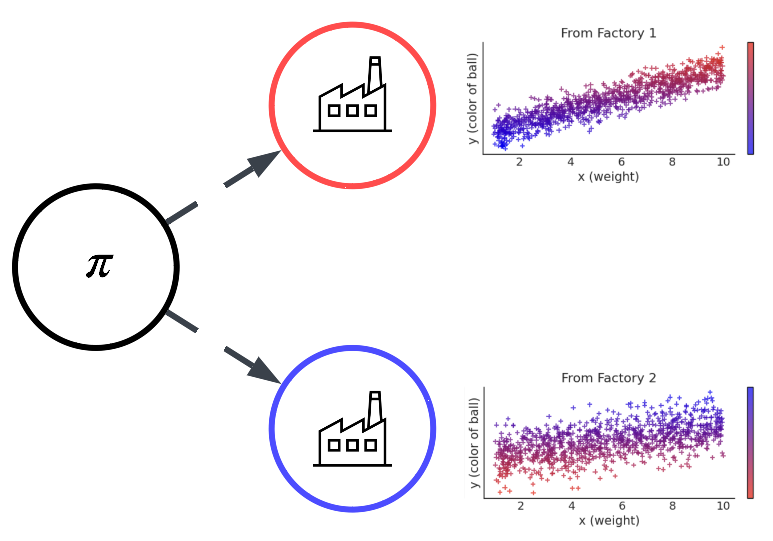

### Steps explaining the synthetic data generation:

- **Step 1**: Randomly assign balls to factories.
  - Factory 1 (70% of the time).
  - Factory 2 (30% of the time).

- **Step 2**: For each ball, generate a weight ($ x $) uniformly between 1 and 10:
  $$
  x \sim \text{Uniform}(1, 10)
  $$

- **Step 3**: Use the corresponding factory's GLM to generate the ball's color ($ y $):
  - If the ball comes from Factory 1: $ y \sim 0.8 \cdot x + 1.5 + \epsilon $
  - If the ball comes from Factory 2: $ y \sim -0.5 \cdot x - 2.0 + \epsilon $
  - Where $ \epsilon $ is small Gaussian noise ($ \mathcal{N}(0, 1) $, $ \mathcal{N}(0, 2) $) to introduce variability.


In [ ]:
w1, w2 = 0.8, -0.5
c1, c2 = 1, -1
sigma1, sigma2 = 1, 2

# Generating the data
# factory = np.random.choice(2, size=500, p=[0.3, 0.7])
x_1 = np.random.uniform(1, 10, size=300) # pi is here :)
x_2 = np.random.uniform(1, 10, size=700)
y_1 = np.random.normal(loc=w1 * x_1 + c1, scale=sigma1)
y_2 = np.random.normal(loc=w2 * x_2 + c2, scale=sigma2)

In [ ]:
# plot the mixture
fig, ax = plt.subplots(1, 2, figsize=(10, 3))

# inside factory 1
cmap1 = mcolors.LinearSegmentedColormap.from_list("gradient", ["blue", "red"])
sc = ax[0].scatter(x_1, y_1, c=y_1, cmap=cmap1, alpha=0.7, marker="+")
fig.colorbar(sc, ticks=[], ax=ax[0])
ax[0].set_ylabel("y (color of ball)")
ax[0].set_yticks([])
ax[0].set_xlabel("x (weight)")
ax[0].set_title("From Factory 1")

cmap2 = mcolors.LinearSegmentedColormap.from_list("gradient", ["red", "blue"])
sc = ax[1].scatter(x_2, 1-y_2, c=1-y_2, cmap=cmap2, alpha=0.7, marker="+")
fig.colorbar(sc, ticks=[], ax=ax[1])
ax[1].set_ylabel("y (color of ball)")
ax[1].set_yticks([])
ax[1].set_xlabel("x (weight)")
ax[1].set_title("From Factory 2")

plt.suptitle("Truth, Hidden. For understanding only. (notice the colorbars)")
plt.show()

In [ ]:
cmap = mcolors.LinearSegmentedColormap.from_list("gradient", ["blue", "red"])
fig, ax = plt.subplots(1, 1, figsize=(6, 3))
tot_x = np.concatenate([x_1, x_2])
tot_y = np.concatenate([y_1, y_2])
sc = plt.scatter(tot_x, tot_y, c=tot_y, cmap=cmap, alpha=0.7, marker="+")
plt.colorbar()
plt.ylabel("y (color of ball)")
plt.xlabel("x (weight)")
plt.title("What you can Observe")
plt.show()

### Mixture of GLM Specification

**Priors**:
- **Mixing Weights**:
  $$
  \pi \sim \text{Dirichlet}(\alpha_1, \alpha_2)
  $$
- **GLM Parameters for Each Component**:
  $$
  w_k \sim \mathcal{N}(0, 1), \quad c_k \sim \mathcal{N}(0, 1), \quad \sigma_k \sim |\mathcal{N}(0, 1)| \quad \text{for } k = 1, 2
  $$

**Likelihood**:
For each observed $ y_n $:
$$
P(y_n | x_n, z_n = k, w_k, c_k, \sigma_k) = \mathcal{N}(x_n \cdot w_k + c_k, \sigma_k^2)
$$
The overall likelihood is a mixture:
$$
P(y_n | x_n, \pi, \{w_k, c_k, \sigma_k\}_{k=1}^2) = \sum_{k=1}^2 \pi_k \mathcal{N}(y_n | x_n \cdot w_k + c_k, \sigma_k^2)
$$

**Posterior**:
Using Bayes' theorem, the posterior is:
$$
P(\pi, \{w_k, c_k, \sigma_k\}_{k=1}^2 | y, x) \propto P(y | x, \pi, \{w_k, c_k, \sigma_k\}_{k=1}^2) P(\pi) \prod_{k=1}^2 P(w_k) P(c_k) P(\sigma_k)
$$

Where:
- $y$ is the observed color of the ball,
- $x$ is the weight of the ball,
- $z$ is the hidden state (factory),
- $\pi$ is the mixing weights,
- $w_k$ and $c_k$ are the weight and intercept parameters for each factory,
- $\sigma_k$ is the noise variance for each factory.

This captures the uncertainty in the mixing weights, GLM parameters, and the latent state assignments.

In [ ]:
#@utility
# Define the Stan model
model_specification = """
data {
    int<lower=0> N; // Number of data points
    int<lower=0> K; // Number of components

    vector[N] x;
    vector[N] y;
}
parameters {
    simplex[K] pi; // Mixture weights
    vector[K] w; // Means
    vector[K] c; // Bias
    vector<lower=0>[K] sigma; // Standard deviations
}
model {
    // Priors
    pi ~ dirichlet(rep_vector(1, K));
    w ~ normal(0, 1);
    c ~ normal(0, 1);
    sigma ~ normal(0, 1);
    
    // Likelihood
    for (n in 1:N) {
        vector[K] log_likelihoods; // Log likelihoods for each component
        for (k in 1:K) {
            log_likelihoods[k] = log(pi[k]) + normal_lpdf(y[n] | x[n] * w[k] + c[k], sigma[k]);
        }
        target += log_sum_exp(log_likelihoods); // Combine log-likelihoods across components
    }
}
"""

# Write the model string to a temporary file
with tempfile.NamedTemporaryFile(suffix=".stan", mode="w", delete=False) as tmp_file:
    tmp_file.write(model_specification)
    tmp_stan_path = tmp_file.name

# Prepare the unknown generator data
data = {
    "N": 1000,
    "K": 2,
    "x": tot_x,
    "y": tot_y,
}

# Compile the model
model = CmdStanModel(stan_file=tmp_stan_path)
fit = model.sample(data=data, iter_sampling=1000, step_size=0.1)

In [ ]:
idata = az.from_cmdstanpy(fit)

# Plot the posterior distribution
ax = az.plot_trace(idata, figsize=(8, 4), compact=True)

**Notice the label switching!!**\
All chains look stable so we will stick with one of them to avoid the switching problem.

In [ ]:
# Notice the posterior samples and how they are stored
idata.posterior.data_vars

In [ ]:
p_pi = idata.posterior.data_vars["pi"].values[0]
p_w = idata.posterior.data_vars["w"].values[0]
p_c = idata.posterior.data_vars["c"].values[0]
p_sigma = idata.posterior.data_vars["sigma"].values[0]

In [ ]:
# Plot the recovered GLMs onto the data

fig, ax = plt.subplots(1, 1, figsize=(8, 4))
# Prepare the data for plotting
cmap = mcolors.LinearSegmentedColormap.from_list("gradient", ["blue", "red"])
sc = plt.scatter(tot_x, tot_y, c=tot_y, cmap=cmap, alpha=0.7, marker="+")

# Plot the uncertainty
for g in range(2):
    for i in range(1000):
        pi = p_pi[i,g]
        w = p_w[i,g]
        c = p_c[i,g]
        sigma = p_sigma[i,g]
        u_y = np.dot(np.array([tot_x, tot_x]).T, w) + c
        plt.plot(tot_x, u_y, color="orange", alpha=0.02)

# Plot the mean of the posterior predictive distribution
p_y_1 = np.dot(np.array([tot_x, tot_x]).T, p_w.mean(0)[0]) + p_c.mean(0)[0]
p_y_2 = np.dot(np.array([tot_x, tot_x]).T, p_w.mean(0)[1]) + p_c.mean(0)[1]
plt.plot(tot_x, p_y_1, color="black", linestyle="--", label="Mean Post. Predictive", linewidth=1)
plt.plot(tot_x, p_y_2, color="black", linestyle="--", label="Mean Post. Predictive", linewidth=1)

plt.colorbar(sc)
plt.ylabel("y (color of ball)")
plt.xlabel("x (weight)")
plt.title("GLM Fit and Uncertainty in Recovered Params")
plt.show()

***Quiz: What would happen if we had 3 factories instead?***

## Input Dependent Markov Models (a.k.a. GLM-HMM)

### Example: Conveyor Belts in the Color Factory

Imagine a **factory** with **three conveyor belts**, each handling different ball-packing operations:
1. **Belt 1 (Red Balls)**:
   - On this belt, the redness of a ball ($ y $) depends positively on its weight ($ x $), so heavier balls are redder.
2. **Belt 2 (Blue Balls)**:
   - Here, the redness depends negatively on the ball’s weight, making heavier balls bluer.
3. **Belt 3 (Neutral Balls)**:
   - This belt doesn’t correlate much with weight, producing balls of all colors.


### The Markovian Twist

Unlike the mixture model (where balls came independently from factories), this process is sequential:
- The conveyor belts operate in a **Markovian sequence**:
  - If the current belt is Belt 1, it’s most likely to switch to Belt 2.
  - If the current belt is Belt 2, it tends to switch to Belt 3.
  - If the current belt is Belt 3, it’s likely to switch back to Belt 1.
- You observe the weight ($ x $) and color ($ y $) of each ball in sequence but cannot directly see the belt ($ z $) it came from.



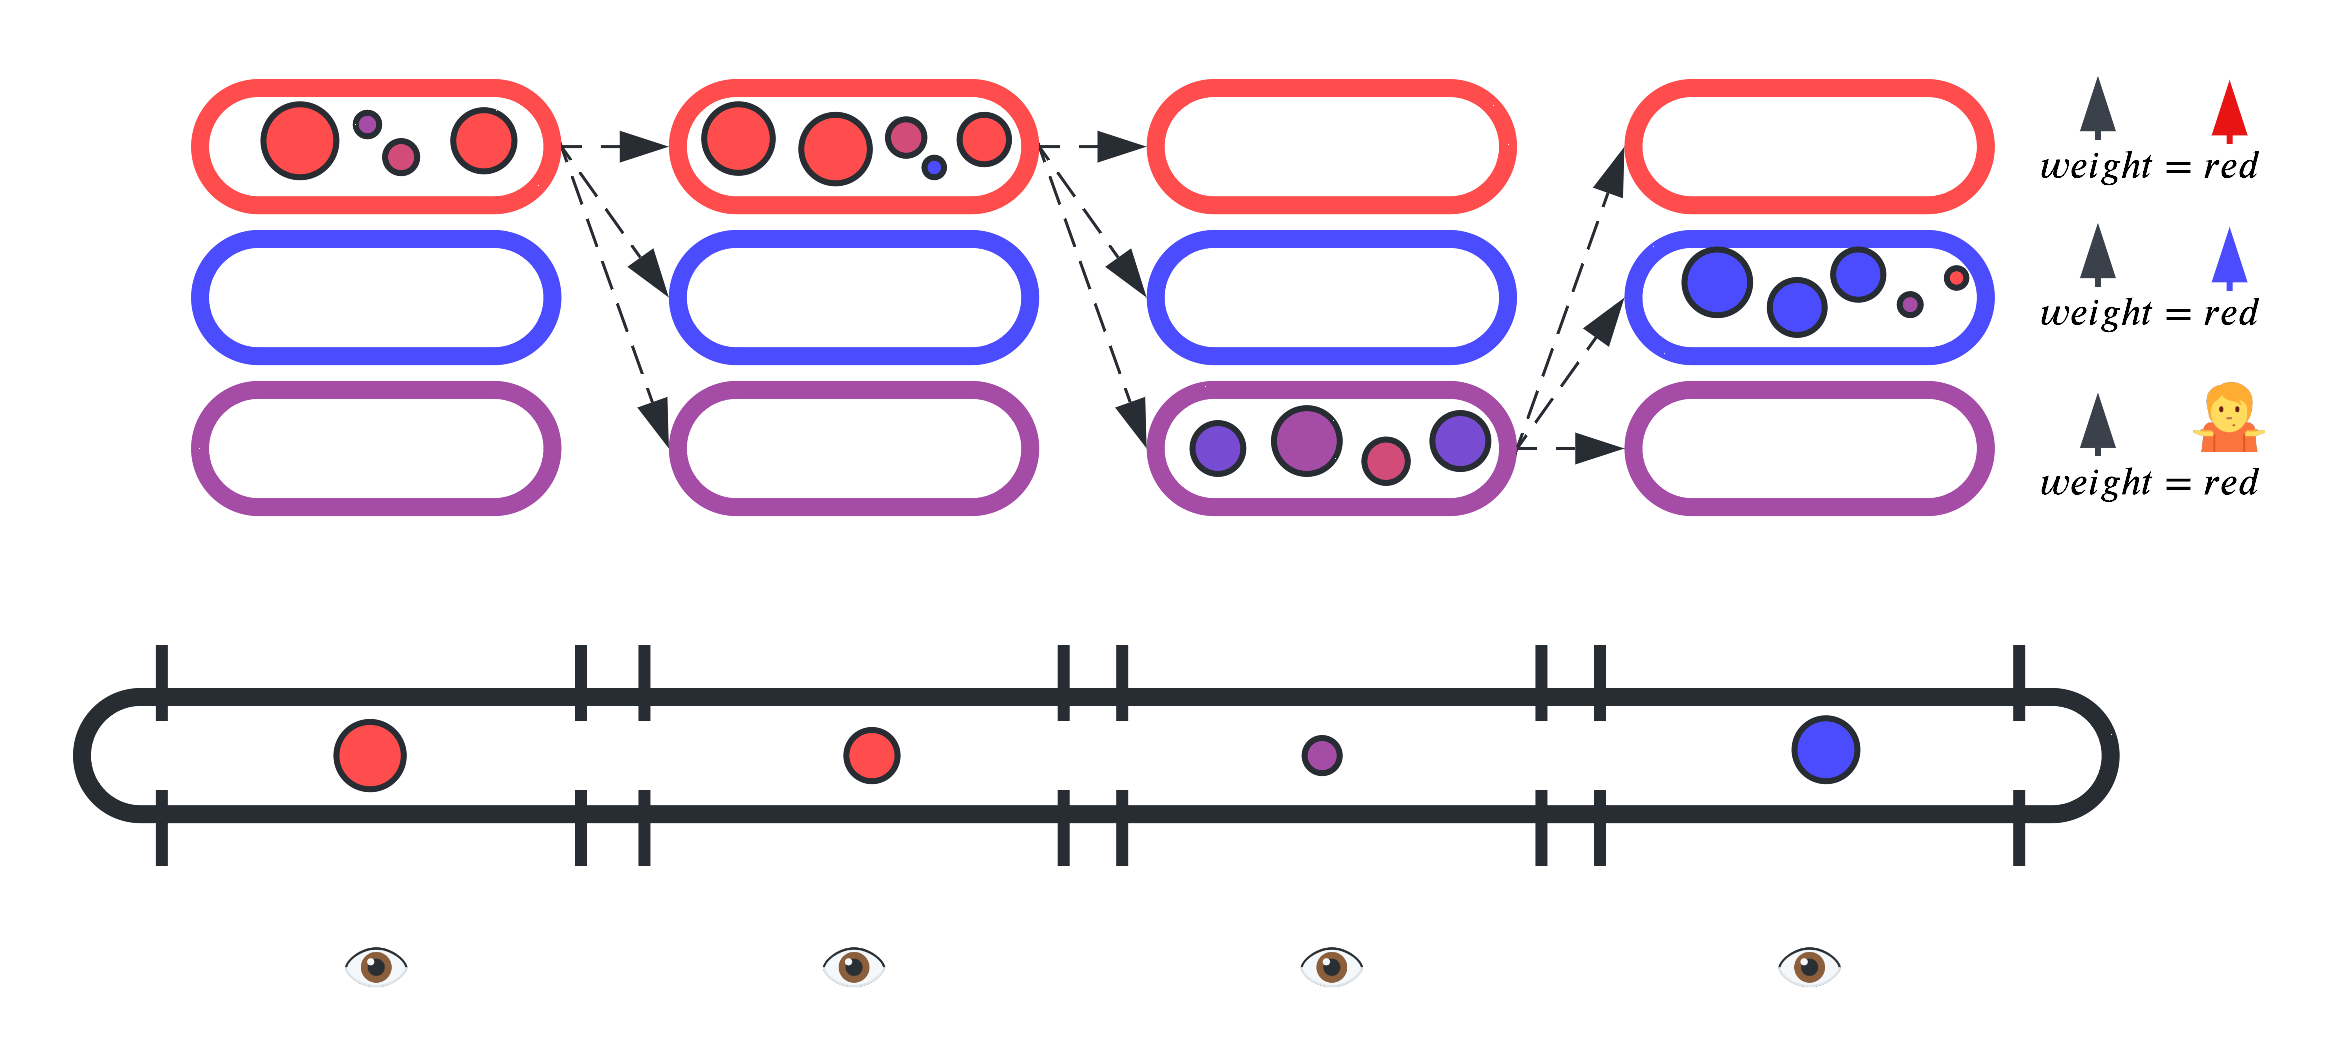


### Details on the Synthetic Data Generation:

1. **Hidden States ($ z_n $)**:
   - The conveyor belt in use at time $ n $ (hidden variable).
   - Follows a **Markov process**, where:
     $$
     P(z_n | z_{n-1}) = \text{Transition Probability Matrix}
     $$
   - Example transition matrix:
     $$
     \begin{bmatrix}
     0.5 & 0.4 & 0.1 \\ 
     0.1 & 0.5 & 0.4 \\ 
     0.4 & 0.1 & 0.5
     \end{bmatrix}
     $$

2. **Observed Data ($ x, y $)**:
   - $ x $: Weight of the ball ($ x \sim \text{Uniform}(1, 10) $).
   - $ y $: Color of the ball, determined by the GLM specific to the belt ($ z_n $).

3. **GLMs for Emission Components**:
   - Each conveyor belt uses a GLM to model the relationship between weight ($ x $) and color ($ y $):
     - **Belt 1 (Red)**: $ y_n \sim \mathcal{N}(w_1 \cdot x_n + c_1, \sigma_1^2) $
     - **Belt 2 (Blue)**: $ y_n \sim \mathcal{N}(w_2 \cdot x_n + c_2, \sigma_2^2) $
     - **Belt 3 (Neutral)**: $ y_n \sim \mathcal{N}(w_3 \cdot x_n + c_3, \sigma_3^2) $
   - Their values:
     - Belt 1: $ w_1 = 1.0, c_1 = 2.0, \sigma_1 = 1.0 $
     - Belt 2: $ w_2 = -0.8, c_2 = -1.0, \sigma_2 = 1.5 $
     - Belt 3: $ w_3 = 0.2, c_3 = 0.0, \sigma_3 = 0.8 $

4. **Sequence Generation**:
   - Start with an initial belt ($ z_1 \sim \pi $, where $ \pi $ is the initial state distribution). (I've given the equal chance to all belts)
   - For each time step $ n $:
     1. Transition to the next belt ($ z_n $) based on the current belt ($ z_{n-1} $).
     2. Generate the weight ($ x_n $) from a uniform distribution.
     3. Generate the color ($ y_n $) using the GLM of the current belt ($ z_n $).

**Okay so now lets generate some data and take a look at it:**

In [ ]:
# Generator params
weights = np.array([1, -0.8, 0.2])
bias = np.array([2, 0, -1])
sigma = np.array([1, 0.8, 1.5])

trans_mat = np.array([
    [0.5, 0.4, 0.1],
    [0.1, 0.5, 0.4],
    [0.4, 0.1, 0.5]])

initial_probs = np.array([1, 1, 1]) / 3

In [ ]:
x = np.linspace(1, 10, 1000)

# GLMs 1 2 3
y_1 = np.random.normal(loc=weights[0] * x + bias[0], scale=sigma[0])
y_2 = np.random.normal(loc=weights[1] * x + bias[1], scale=sigma[1])
y_3 = np.random.normal(loc=weights[2] * x + bias[2], scale=sigma[2])

# viz the data
col_line = mcolors.LinearSegmentedColormap.from_list("gradient", ["blue", "red"])
plt.figure(figsize=(6, 3))
plt.scatter(np.concatenate([x, x, x]), np.concatenate([y_1, y_2, y_3]), alpha=0.7, c=np.concatenate([y_1, y_2, y_3]), cmap=col_line, marker="+")
plt.colorbar(ticks=[])
plt.ylabel("y (color of ball)")
plt.xlabel("x (weight)")
plt.yticks([])
plt.title("If we did not care for the sequence of ball arrival!")
plt.show()

***As you can see from above, if the balls all came in the same bag at once, there would not be any markovian process. In that case it just boils down to a mixture!***\
Now lets make these balls come in sequences

In [ ]:
# First set some global constants
num_states = 3
emission_dim = 1
covariate_dim = 1
num_timesteps = 100
batch_size = 10

# Set up an iterator to yield JAX PRNGKey's
keys = map(jr.PRNGKey, count())

In [ ]:
# Simulate data from a "true" model with randomly initialized parameters
hmm = LinearRegressionHMM(num_states, covariate_dim, emission_dim)

true_params, _ = hmm.initialize(next(keys),
                                initial_probs=jnp.array(initial_probs),
                                transition_matrix= jnp.array(trans_mat),
                                emission_weights=jnp.array(weights.reshape(-1, 1)),
                                emission_biases= jnp.array(bias.reshape(-1, 1)),
                                emission_covariances= jnp.array(sigma.reshape(-1, 1, 1)))


In [ ]:
# Now make a time series of inputs. These are the inputs to the linear regression.
batch_inputs = jnp.array(np.random.uniform(0, 10, size=(batch_size, num_timesteps, covariate_dim)))

inputs = (jnp.sin(2 * jnp.pi * jnp.arange(num_timesteps) / 50)*4 + 5).reshape(-1, 1)

# Sample from the true model
true_states, emissions = hmm.sample(true_params, next(keys), num_timesteps, inputs=jnp.array(inputs))

batch_true_states, batch_emissions = [], []

for i in range(batch_size):
    a, b = hmm.sample(true_params, next(keys), num_timesteps, inputs=batch_inputs[i])
    batch_true_states.append(a)
    batch_emissions.append(b)
batch_true_states = jnp.array(batch_true_states)
batch_emissions = jnp.array(batch_emissions)

# Compute the marginal log probability of the emissions under the true model
true_lp = hmm.marginal_log_prob(true_params, emissions, inputs=jnp.array(inputs))

In [ ]:
plt.figure(figsize=(12, 3))
col_line = mcolors.LinearSegmentedColormap.from_list("gradient", ["blue", "red"])
plt.scatter(jnp.arange(num_timesteps), emissions, c=emissions, cmap=col_line, marker='o', s=100)
plt.colorbar()
plt.ylabel("Emission Color")
plt.xlabel("Time")
plt.title("If you were given this, could you tell which belt each point came from?")
plt.show()

In [ ]:
# Plot the inputs and emissions, along with the true states
fig, axs = plt.subplots(2, 1, sharex=True, gridspec_kw={"height_ratios": [2, 4]}, figsize=(12, 4))

em_max= emissions.max() + 2
em_min = emissions.min() - 2

offsets = 3 * jnp.arange(covariate_dim)
axs[0].plot(inputs + offsets, 'k-', marker='.')
axs[0].set_xlim(0, num_timesteps)
axs[0].set_ylim(0, 10)
axs[0].set_ylabel("weight")
# axs[0].set_xlabel("time")

col_line = mcolors.LinearSegmentedColormap.from_list("gradient", ["blue", "red"])
offsets = 3 * jnp.arange(emission_dim)
axs[1].imshow(true_states[None, :],
              extent=(0, num_timesteps, em_min, em_max),
              aspect="auto",
              cmap="Grays",
              alpha=0.5)
axs[1].plot(emissions + offsets, 'k--', marker='.')
axs[1].scatter(jnp.arange(num_timesteps), emissions, c=emissions, cmap=col_line, marker='o', s=100)
axs[1].set_xlim(0, num_timesteps)
axs[1].set_ylim(em_min, em_max)
axs[1].set_ylabel("emissions (color)")
axs[1].set_xlabel("Time")

# Zoom in on a smaller slice of data
axs[1].set_xlim(0, num_timesteps)
plt.suptitle("True Simulated Data")
plt.show()

**Can you tell the belts apart now? 🔎**\
Lets now make a GLM-HMM automatically figure out which belt the balls most likely came from.

### GLM-HMM Specification (Switching Linear Regression)

**1. Emissions (GLM for Observed Data)**:
- The observed data $ y_t $ at time $ t $ is modeled as a Gaussian distribution:
  $$
  y_t \mid x_t, z_t = k \sim \mathcal{N}(x_t \cdot w_k + c_k, \sigma_k^2)
  $$
  where:
  - $ z_t \in \{1, 2, \dots, K\} $: Discrete latent state (e.g., which conveyor belt is active at time $ t $).
  - $ x_t $: Input feature (e.g., ball weight).
  - $ w_k $: Weight for the linear relationship in state $ k $.
  - $ c_k $: Bias (intercept) for state $ k $.
  - $ \sigma_k^2 $: Variance of the Gaussian noise for state $ k $.

**2. Latent States (Markov Process)**:
- The discrete latent states $ z_t $ follow a **Markov process**:
  $$
  z_1 \sim \pi, \quad z_{t+1} \mid z_t \sim P_{z_t}
  $$
  where:
  - $ \pi $: Initial state distribution.
  - $ P_{z_t} $: Transition probability matrix ($ P $) describing the probabilities of transitioning from one state to another.


**Priors on Markov Model Parameters**:
$$
\pi \sim \text{Dirichlet}(\alpha_{\pi})
$$
$$
P_{z_t} \sim \text{Dirichlet}(\alpha_P)
$$
$$
w_k \sim \mathcal{N}(0, 1), \quad c_k \sim \mathcal{N}(0, 1) \quad \text{for } k = 1, \dots, K
$$
$$
\sigma_k \sim |\mathcal{N}(0, 1)| \quad \text{for } k = 1, \dots, K
$$

Where:
- $ \alpha_{\pi} $ and $ \alpha_P $ are the Dirichlet hyperparameters.
- $ w_k, c_k, \sigma_k $ are the GLM parameters for each state $ k $.


**Likelihood**:

For each observed $ y_t $:
1. Conditioned on the hidden state $ z_t $, the likelihood is:
   $$
   P(y_t \mid x_t, z_t = k, w_k, c_k, \sigma_k) = \mathcal{N}(y_t \mid x_t \cdot w_k + c_k, \sigma_k^2)
   $$
2. The full likelihood marginalizes over all possible hidden states:
   $$
   P(y_t \mid x_t, \pi, P, \{w_k, c_k, \sigma_k\}_{k=1}^K) = \sum_{k=1}^K P(z_t = k \mid z_{t-1}, P) \cdot \mathcal{N}(y_t \mid x_t \cdot w_k + c_k, \sigma_k^2)
   $$

**Posterior** 👀:

Using Bayes' theorem, the posterior is:
$$
P(\pi, P, \{w_k, c_k, \sigma_k\}_{k=1}^K \mid y_{1:T}, x_{1:T}) \propto P(y_{1:T} \mid x_{1:T}, \pi, P, \{w_k, c_k, \sigma_k\}_{k=1}^K) \cdot P(\pi) \cdot P(P) \cdot \prod_{k=1}^K P(w_k) P(c_k) P(\sigma_k)
$$
  
Where:
- $ P(y_{1:T} \mid x_{1:T}, \pi, P, \{w_k, c_k, \sigma_k\}_{k=1}^K)$ is the likelihood of observing the data given the parameters.
- $ P(\pi) $, $ P(P) $, and $ P(w_k) $, $ P(c_k) $, $ P(\sigma_k) $ are the prior distributions of the parameters.

### How to solve this? 😱

We can solve it the same way we have been solving till now. However, the **Markovian nature** of the model introduces **dependencies** between the observations, making it more complex to solve than the previous models. Making full Bayesian inference computationally **VERY** expensive.

Optimizations (Dont need to understand all of it):
1. **Parameter Estimation**:
    - Estimate $ \pi, P, w_k, c_k, \sigma_k $ by maximizing the marginal likelihood:
     $$
     \mathcal{L}(\theta) = \log P(y_{1:T} \mid x_{1:T}, \theta)
     $$
    - This is used during the E-step in EM.
2. **Viterbi Algorithm**:
    - Finds the single most likely sequence of states.

**lets go and train it!**

In [ ]:
# Now fit another model to the simulated data
test_params, param_props = hmm.initialize(next(keys))

# To fit the model, give it a batch of emissions and a batch of corresponding inputs
# test_params, lps = hmm.fit_em(test_params, param_props, emissions, inputs=inputs)
test_params, lps = hmm.fit_em(test_params, param_props, batch_emissions, inputs=batch_inputs)

In [ ]:
def plot_states(true_states, most_likely_states, emissions, title="Did the HMM get it right?"):
    # Plot the true and inferred states
    fig, axs = plt.subplots(2, 1, sharex=True, gridspec_kw={"height_ratios": [2, 2]}, figsize=(12, 6))

    for i, states in enumerate([true_states, most_likely_states]):
        offsets = 3 * jnp.arange(emission_dim)
        axs[i].imshow(states[None, :],
                    extent=(0, num_timesteps, em_min, em_max),
                    aspect="auto",
                    cmap="binary",
                    alpha=0.5)
        axs[i].plot(emissions + offsets, 'k-', marker='.')
        axs[i].scatter(jnp.arange(num_timesteps), emissions, c=emissions, cmap=col_line, marker='o', s=100)
        axs[i].set_xlim(0, num_timesteps)
        axs[i].set_ylim(em_min, em_max)
        axs[i].set_ylabel("emissions")
        axs[i].set_xlabel("time")

    axs[0].set_title("true states")
    axs[1].set_title("inferred states")
    plt.suptitle(title)

# Bar graph plotting function
def plot_param_comparison(param, r_param, title, ylabel, ax=None, width = 0.35):

    if ax is None:
        fig, ax = plt.subplots(figsize=(6, 3))

    states = np.arange(1, len(weights) + 1)
    x = np.arange(len(param))
    colors= get_color_gradient(2)
    # #FFAF00 #F46920
    ax.bar(x - width / 2, param, width, label='Generator', color=colors[0], alpha=0.7)
    ax.bar(x + width / 2, r_param, width, label='Recovered', color=colors[1], alpha=0.7)
    ax.set_xticks(x, [f'State {i}' for i in states])
    ax.set_title(title)
    ax.set_ylabel(ylabel)
    ax.set_xlabel('States')
    ax.legend()

In [ ]:
# Compute the most likely states
most_likely_states = hmm.most_likely_states(test_params, emissions, inputs=inputs)
plot_states(true_states, most_likely_states, emissions)

It looks pretty bad doesnt it? But look closer, the background gray colors dont mean the same thing. Its our old friend LABEL SWITCHING! 🤪\
Lets align them and look at it again.

In [ ]:
permutation = find_permutation(true_states, most_likely_states)
remapped_states = permutation[true_states]
plot_states(remapped_states, most_likely_states, emissions, title="How about now after alignment?")

#### **QUIZ**: Why does it get 40 and 90 +-10 exceptionally wrong? (Even after label switching considered, why is it extra difficult?) Hint: Look at the input closely

Finally, we can check the parameter recovery for the GLM-HMM. And see how did it do!

In [ ]:
t_tr = np.array(test_params.transitions.transition_matrix)
t_init = np.array(test_params.initial.probs).reshape(-1)
t_weights = np.array(test_params.emissions.weights).reshape(-1)
t_covs = np.array(test_params.emissions.covs).reshape(-1)
t_bias = np.array(test_params.emissions.biases).reshape(-1)

In [ ]:
# 2 transition matrices side by side
fig, ax = plt.subplots(1, 2, figsize=(6, 3))

ht = sns.heatmap(trans_mat[permutation, :][:, permutation], ax=ax[0], cmap="Greens", annot=True, cbar=False, vmax=1, vmin=0)
ht.set_title("True Transition Matrix")

ht = sns.heatmap(t_tr, ax=ax[1], cmap="Greens", annot=True, cbar=False, vmax=1, vmin=0)
ht.set_title("Recovered Transition Matrix")
plt.show()

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(10, 6))

# Plot each parameter comparison
plot_param_comparison(weights[permutation], t_weights, "Weights Comparison", "Weight Value", ax=ax[0, 0])
plot_param_comparison(bias[permutation], t_bias, "Bias Comparison", "Bias Value", ax=ax[0, 1])
plot_param_comparison(sigma[permutation], t_covs, "Sigma Comparison", "Sigma Value", ax=ax[1, 0])
plot_param_comparison(initial_probs[permutation], t_init, "Initial Probabilities Comparison", "Probability", ax=ax[1, 1])

***considering these are point estimates from only 10 batches, the results are pretty good!***

Thank you for attending my Ted Talk! 🙇🎤